In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from prepareDF import PrepareDF
from sklearn import preprocessing
import torch
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

1b) Importing and Preparing Dataset from files

In [116]:
MovieData = PrepareDF()
MovieData.head()

,title,director,cast,rating,genres
0,Ganglands,Julien Leclercq,"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, ...",7.2,"[Crime TV Shows, International TV Shows, TV ..."
1,Midnight Mass,Mike Flanagan,"[Kate Siegel, Zach Gilford, Hamish Linklater...",7.7,"[TV Dramas, TV Horror, TV Mysteries]"
2,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","[Vanessa Hudgens, Kimiko Glenn, James Marsde...",6.8,[Children & Family Movies]
3,Sankofa,Haile Gerima,"[Kofi Ghanaba, Oyafunmike Ogunlano, Alexandr...",7.0,"[Dramas, Independent Movies, International M..."
4,The Great British Baking Show,Andy Devonshire,"[Mel Giedroyc, Sue Perkins, Mary Berry, Pau...",8.6,"[British TV Shows, Reality TV]"


In [117]:
for ind, row in MovieData.iterrows():
    string = ''
    for genre in MovieData['genres'][ind]:
        string += genre+'|'
    MovieData['genres'][ind] = string[:-1]

In [118]:
labelEncoder = preprocessing.LabelEncoder()

# Converting the string in the director and title column to float -> Makes no difference to the computer
MovieData['director'] = labelEncoder.fit_transform(MovieData['director'].values)

# Since the cast has way too many poeple, we are going to select the 4 with the most screen time
MovieData['cast'] = MovieData['cast'].to_list()

# Creatinng new columns for individual cast
for i in range(4):
    MovieData[f'cast_{i+1}'] = ''

for ind, item in enumerate(MovieData['cast']):
    MovieData['cast']
    for index, cast_a in enumerate(item[:4]):
        MovieData[f'cast_{index+1}'][ind] = cast_a

MovieData.drop(columns=['cast'], inplace=True)

MovieData['cast_1'] = labelEncoder.fit_transform(MovieData['cast_1'].values)
MovieData['cast_2'] = labelEncoder.fit_transform(MovieData['cast_2'].values)
MovieData['cast_3'] = labelEncoder.fit_transform(MovieData['cast_3'].values)
MovieData['cast_4'] = labelEncoder.fit_transform(MovieData['cast_4'].values)

MovieData['genres']=labelEncoder.fit_transform(MovieData['genres'].values)

MovieData.head()

,title,director,rating,genres,cast_1,cast_2,cast_3,cast_4
0,Ganglands,1787,7.2,196,2881,3435,3109,2559
1,Midnight Mass,2437,7.7,336,1709,3621,1295,1391
2,My Little Pony: A New Generation,3025,6.8,93,3349,1910,1493,3387
3,Sankofa,1276,7.0,238,1809,2635,135,2641
4,The Great British Baking Show,253,8.6,89,2191,3277,2304,2800


In [119]:
# Calculate average ratings for director, genre, and cast
MovieData['director_avg_rating'] = MovieData.groupby('director')['rating'].transform('mean')
MovieData['genre_avg_rating'] = MovieData.groupby('genres')['rating'].transform('mean')
MovieData['cast_avg_rating'] = MovieData[['cast_1', 'cast_2', 'cast_3', 'cast_4']].mean(axis=1)

In [120]:
# Create interaction features
MovieData['director_genre_interaction'] = MovieData['director'] * MovieData['genres']
MovieData['director_cast_interaction'] = MovieData['director'] * MovieData['cast_avg_rating']
MovieData['genre_cast_interaction'] = MovieData['genres'] * MovieData['cast_avg_rating']

In [121]:
# One-hot encoding for genres
MovieData = pd.get_dummies(MovieData, columns=['genres'])

# Machine Learning

In [140]:
# Split the data into training and testing sets
X = MovieData.drop(columns=['title', 'rating', 'director', 'cast_1', 'cast_2', 'cast_3', 'cast_4'])
y = MovieData['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [141]:
X = torch.tensor(X.values)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

Processing the movie dataframe for machine learning

In [124]:
#import torch
import torch.nn as nn
import torch.nn.functional as F

#create a neural network from the pytorch module, 1 input layer, 3 hidden layer, 1 output
class Rate(nn.Module):
    def __init__(self, predictor = 6, h1 = 36, h2 = 96, h3 = 192, h4=95, h5=80, h6 =20 , predict = 10):
        super().__init__()
        self.fc1 = nn.Linear(predictor , h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.fc6 = nn.Linear(h5, h6)
        self.out = nn.Linear(h6, predict)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.out(x)
        
        return x
    

rate = Rate()

print(rate)

Rate(
  (fc1): Linear(in_features=6, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=192, bias=True)
  (fc4): Linear(in_features=192, out_features=95, bias=True)
  (fc5): Linear(in_features=95, out_features=80, bias=True)
  (fc6): Linear(in_features=80, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=10, bias=True)
)


In [125]:
#Set criterion
criterion = nn.CrossEntropyLoss()

#Choose Optimizer
optimizer = torch.optim.Adam(rate.parameters(), lr=0.01)

In [126]:
epoch = 1500
losses = []

for i in range(epoch):
    #passing inputs through the network
    y_pred = rate.forward(X)
    
     #measure the loss at each iteration
    loss = criterion(y_pred,y)
   
    #keep track of progress
    losses.append(loss.detach().numpy())
    
    #print every selected interval
    if i%10 == 0:
        print(f'epoch: {i} and loss {loss}')
    
    #optimizing the model/feedback
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataFrame

Text(0.5, 0, 'Epoch')

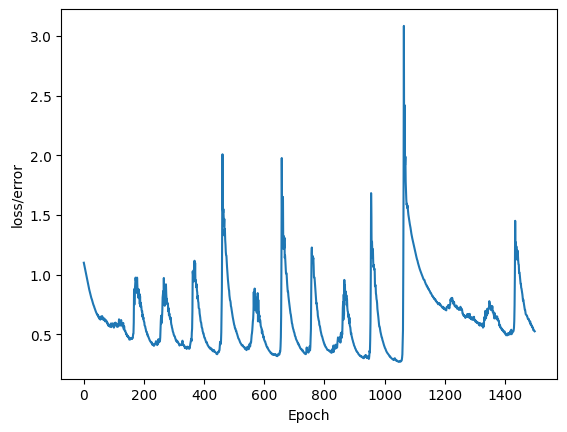

In [ ]:
#Graphing the loss over iterations
plt.plot(range(epoch),losses)
plt.ylabel('loss/error')
plt.xlabel('Epoch')

In [ ]:
X_test = X_test.values
Y_test = Y_test.values

X_test = torch.FloatTensor(X_test)
Y_test = torch.LongTensor(Y_test)

TypeError: new(): data must be a sequence (got builtin_function_or_method)

In [ ]:
with torch.no_grad():
    y_eval = rate.forward(X_test)
    loss = criterion(y_eval, Y_test)

In [ ]:
loss

tensor(3.1876)

In [ ]:
correct = 0

with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = rate.forward(data)
        
        #print(f'{i+1}.) {str(y_val)}\t {Y_test[i]}\t{y_val.argmax().item()}')
        print(f'{i+1}.) {Y_test[i]}\t{y_val.argmax().item()}')
        
        if y_val.argmax().item() == Y_test[i]: 
            correct += 1

            
    print(f'We got {correct} correct')

1.) 6	7
2.) 2	6
3.) 6	6
4.) 7	5
5.) 7	7
6.) 8	5
7.) 7	8
8.) 6	6
9.) 8	7
10.) 6	7
11.) 8	6
12.) 7	6
13.) 5	6
14.) 4	8
15.) 7	6
16.) 7	6
17.) 7	5
18.) 7	6
19.) 5	5
20.) 7	7
21.) 6	5
22.) 6	5
23.) 6	6
24.) 5	5
25.) 6	5
26.) 6	5
27.) 6	5
28.) 7	7
29.) 7	6
30.) 5	7
31.) 5	7
32.) 3	6
33.) 5	7
34.) 6	6
35.) 6	5
36.) 8	7
37.) 7	7
38.) 6	5
39.) 6	5
40.) 7	5
41.) 5	6
42.) 6	5
43.) 5	6
44.) 7	7
45.) 4	7
46.) 5	5
47.) 6	5
48.) 7	5
49.) 5	6
50.) 5	6
51.) 4	7
52.) 5	5
53.) 5	6
54.) 7	7
55.) 7	6
56.) 6	6
57.) 6	6
58.) 7	5
59.) 7	6
60.) 5	7
61.) 2	6
62.) 4	5
63.) 6	6
64.) 5	7
65.) 5	7
66.) 7	7
67.) 4	7
68.) 6	6
69.) 6	6
70.) 5	5
71.) 4	5
72.) 6	7
73.) 5	7
74.) 3	6
75.) 5	6
76.) 6	7
77.) 7	5
78.) 6	7
79.) 8	7
80.) 6	6
81.) 7	7
82.) 4	7
83.) 4	8
84.) 5	6
85.) 6	6
86.) 7	7
87.) 7	6
88.) 7	6
89.) 6	7
90.) 6	5
91.) 6	5
92.) 7	7
93.) 7	7
94.) 6	7
95.) 7	5
96.) 7	6
97.) 2	7
98.) 5	6
99.) 5	6
100.) 6	7
101.) 5	6
102.) 7	7
103.) 6	5
104.) 6	7
105.) 6	6
106.) 6	7
107.) 7	6
108.) 6	6
109.) 6	7
110.) 5	6
111.) 7	